In [5]:
from typing import Annotated, Literal, TypedDict

from langchain_core.messages import HumanMessage
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

In [9]:
from fastapi import FastAPI
from langserve import add_routes
from langserve.pydantic_v1 import BaseModel, Field

In [7]:
from dotenv import load_dotenv
import os

load_dotenv()  # take environment variables from .env.

api_key = os.getenv("OPENAI_API_KEY")

In [8]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
llm = ChatOpenAI(
    openai_api_key=api_key, model="gpt-3.5-turbo", temperature=0, streaming=True
)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
mygraph = graph_builder.compile()
output = mygraph.invoke({"messages": ["Hello, how are you?"]})
print(output["messages"])

[HumanMessage(content='Hello, how are you?', id='0fbb5c1a-b0b9-47cc-91dc-debc40d92883'), AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here to help you. How can I assist you today?", response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-b81d7ae9-0d46-4d26-8e89-bb6a9ab94c3c-0')]


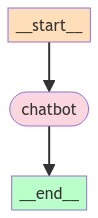

In [13]:
from IPython.display import Image, display

try:
    display(Image(mygraph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
app = FastAPI(
    title="LangChain Server",
    version="1.0",
    description="Spin up a simple api server using LangChain's Runnable interfaces",
)

add_routes(
    app,
    mygraph,
    path="/chat",
)

In [11]:
import uvicorn

uvicorn.run(app, host="localhost", port=8000)

RuntimeError: asyncio.run() cannot be called from a running event loop